In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import datetime
import tqdm.notebook as tqdm

In [2]:
# Create an EV class with the following attributes:
# - Brand
# - Model
# - Battery type
# - Battery size
# - Charging Efficiency
# - Discharging Efficiency
# - Energy per km
# - SOC min
# - SOC max
# - Probability in population - this is the probability that a car of this type will be chosen from the population

class EV:
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population):
        self.brand = brand
        self.model = model
        self.battery_type = battery_type
        self.battery_size = battery_size
        self.charging_efficiency = charging_efficiency if charging_efficiency <= 1 or charging_efficiency >= 0 else 0.9
        self.discharging_efficiency = discharging_efficiency if discharging_efficiency <= 1 or discharging_efficiency >= 0 else 0.9
        self.energy_per_km = energy_per_km
        self.soc_min = soc_min if soc_min >= 0.0 else 0.0
        self.soc_max = soc_max if soc_max <= 1.0 else 1.0
        self.probability_in_population = probability_in_population if probability_in_population <= 1.0 else 1.0


# Extend the class to create drivable EVs
class DrivableEV(EV):

    # __init__ method is inherited from EV class, extended with the state of charge. Creates the following attributes:
    # - State of Charge
    # - List of trips
    # - Current trip
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, initial_soc=None, stopping_soc=None):
        super().__init__(brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population)

        # EV ID
        self.ev_id = secrets.token_hex(16)

        # SOC variables
        self.soc = [initial_soc]
        self.current_soc = initial_soc
        # Attribute a random SOC to stop the EV if none is provided
        self.stopping_soc = stopping_soc if stopping_soc is not None else np.random.uniform(0.2, 0.3, 1)[0]

        # List of trips and current trip
        self.trips = []
        self.split_trips = []

        # User profile
        self.user_profile = None

        # Placeholder for the charging station pools that the EV will use
        self.default_charging_stations_pool = None
        self.segment_charging_stations_pool = None

        # Placeholder for the charging station that the EV will use
        self.default_charging_station = None
        self.segment_charging_station = None

        # Create a list of charging stations
        self.charging_stations_list = []

        # Number of stops
        self.number_of_stops = 0

        # Charging times
        self.charging_start_time = []
        self.charging_end_time = []
        self.charging_type = []
        self.charging_power = []
        self.charging_start_soc = []
        self.charging_end_soc = []

        # Driving Logs
        self.driving_start_time = []
        self.driving_end_time = []
        self.driving_start_soc = []
        self.driving_end_soc = []
        self.driving_distance = []
        self.driving_energy_consumption = []

        # Flexibility logs
        self.flexibility_start_time = []
        self.flexibility_end_time = []
        self.flexibility_type = []
        self.flexibility_power = []
        self.flexibility_start_soc = []
        self.flexibility_end_soc = []


    # Format the print
    def __repr__(self):
        return f"{self.brand} {self.model} with {self.battery_size} kWh battery"


    # Create a method to add a trip to the EV
    def add_trip(self, trip):
        self.trips.append(trip)


    # Create a method to charge the EV
    def charge(self, charge_amount):
        self.current_soc += charge_amount * self.charging_efficiency

        if self.current_soc > 1.0:
            self.current_soc = 1.0

        self.soc.append(self.current_soc)


    # Create a method to charge the EV to a certain SOC. This is used for the segment charging and outputs the amount of energy charged and time taken to charge
    def charge_to_soc(self, target_soc, cs_charging_power, cs_charging_efficiency, charge_ev=True):
        # Calculate the amount of energy needed to charge the EV
        energy_needed = (target_soc - self.current_soc) * self.battery_size if target_soc > self.current_soc else 0.0

        cs_charging_efficiency = min(cs_charging_efficiency, self.charging_efficiency)

        # Calculate the time needed to charge the EV
        time_needed = energy_needed / (cs_charging_power * cs_charging_efficiency)
        time_needed = datetime.timedelta(hours=time_needed)

        # Charge the EV
        if charge_ev:
            self.charge(energy_needed / self.battery_size)

        return energy_needed, time_needed


    # Create a method to log the charging of the EV
    def log_charging(self, charging_start_time, charging_end_time, charging_type, charging_power, charging_start_soc, charging_end_soc):
        self.charging_start_time.append(charging_start_time)
        self.charging_end_time.append(charging_end_time)
        self.charging_type.append(charging_type)
        self.charging_power.append(charging_power)
        self.charging_start_soc.append(charging_start_soc)
        self.charging_end_soc.append(charging_end_soc)


    # Create a method to log the flexibility of charge of the EV
    def log_flexibility(self, flexibility_start_time, flexibility_end_time, flexibility_type, flexibility_power, flexibility_start_soc, flexibility_end_soc):
        self.flexibility_start_time.append(flexibility_start_time)
        self.flexibility_end_time.append(flexibility_end_time)
        self.flexibility_type.append(flexibility_type)
        self.flexibility_power.append(flexibility_power)
        self.flexibility_start_soc.append(flexibility_start_soc)
        self.flexibility_end_soc.append(flexibility_end_soc)


    # Create a method to log the driving of the EV
    def log_driving(self, driving_start_time, driving_end_time, driving_start_soc, driving_end_soc, driving_distance, driving_energy_consumption):
        self.driving_start_time.append(driving_start_time)
        self.driving_end_time.append(driving_end_time)
        self.driving_start_soc.append(driving_start_soc)
        self.driving_end_soc.append(driving_end_soc)
        self.driving_distance.append(driving_distance)
        self.driving_energy_consumption.append(driving_energy_consumption)


    # Create a method to discharge the EV
    def discharge(self, discharge_amount):
        self.current_soc -= discharge_amount / self.discharging_efficiency

        if self.current_soc < 0:
            self.current_soc = 0

        self.soc.append(self.current_soc)


    # Create a method to assign the allowed charging stations by the profile
    def assign_charging_stations(self):

        # Check if charging stations were already assigned
        if len(self.charging_stations_list) > 0:
            return

        # Get the charging stations from the profile
        allowed_charging_stations = self.trips[0].profile.allowed_charging_stations

        # Default stations
        self.default_charging_stations_pool = allowed_charging_stations['Default']

        # Segment stations
        self.segment_charging_stations_pool = allowed_charging_stations['Segment']

        # Pick the default charging station
        self.default_charging_station = np.random.choice(self.default_charging_stations_pool, 1,
                                                         p=[x.charging_station_probability for x in self.default_charging_stations_pool])[0]
        self.default_charging_station.ev_id = self.ev_id

        # Pick the segment charging station
        self.segment_charging_station = np.random.choice(self.segment_charging_stations_pool, 1,
                                                         p=[x.charging_station_probability for x in self.segment_charging_stations_pool])[0]
        self.segment_charging_station.ev_id = self.ev_id

        # Create a list of charging stations
        self.charging_stations_list = [self.default_charging_station, self.segment_charging_station]


    # Create a method to check necessity of trip splitting and charging
    def trip_splitting(self):

        # Placeholder for the list of trips
        list_split_trips = []

        # Placeholder for the current time
        current_time = datetime.datetime(2023, 1, 1, 0, 0, 0)

        # Check if the profile allows charging during the day
        charge_during_day = self.user_profile.charge_during_day
        charge_during_night = self.user_profile.charge_during_night
        soc_min_tocharge = self.user_profile.soc_min_tocharge

        # Check if SOC is below the minimum. If yes, charge the EV to capacity specified on the Profile.
        if self.current_soc < self.stopping_soc:

            temp_soc = self.current_soc

            charge_energy, charge_time = self.charge_to_soc(soc_min_tocharge,
                                                            self.default_charging_station.charging_station_power,
                                                            self.default_charging_station.charging_station_efficiency)
            self.log_charging(current_time, current_time + charge_time,
                              self.default_charging_station.charging_station_type,
                              self.default_charging_station.charging_station_power,
                              temp_soc,
                              self.current_soc)

            # Update current time
            current_time += charge_time

        # Loop over the trips
        for i in range(len(self.trips)):

            trip = self.trips[i]

            # Check how much the EV can cover with the current SOC
            possible_trip_length = np.round((self.current_soc - self.stopping_soc) * self.battery_size / self.energy_per_km, 2)

            # If the trip can be covered, add it to the list
            if possible_trip_length >= trip.trip_length:
                list_split_trips.append(trip)

                # SOC before the trip
                temp_soc = self.current_soc

                # Discharge the required SOC
                self.discharge(trip.trip_required_soc)

                # Register driving logs
                self.log_driving(trip.trip_start_time, trip.trip_end_time,
                                 temp_soc, self.current_soc, trip.trip_length, trip.trip_required_soc)

                # Update the current time
                current_time = trip.trip_end_time

                trip.covered_distance = trip.trip_length

            # If the trip cannot be covered, split it
            else:

                current_covered_distance = 0
                current_trip_start_time = trip.trip_start_time

                # Loop over the trip
                while current_covered_distance < trip.trip_length:

                    # Calculate the possible trip length
                    possible_trip_length = np.round((self.current_soc - self.stopping_soc) * self.battery_size / self.energy_per_km, 2)

                    # Calculate the trip length
                    trip_length = min(possible_trip_length, trip.trip_length - current_covered_distance)

                    # Calculate the trip duration
                    trip_duration = datetime.timedelta(hours=trip_length / trip.trip_speed)

                    # Calculate the trip end time
                    trip_end_time = current_trip_start_time + trip_duration

                    # Create a new trip
                    new_trip = DrivableTrip(trip_length, trip.trip_speed,
                                            current_trip_start_time, trip_end_time,
                                            trip_duration, profile=trip.profile, trip_id=trip.trip_id)
                    new_trip.ev = self
                    new_trip.ev_id = self.ev_id
                    new_trip.trip_energy_consumption = trip_length * self.energy_per_km
                    new_trip.trip_required_soc = new_trip.trip_energy_consumption / self.battery_size
                    new_trip.assign_ev_battery_size()
                    new_trip.covered_trip_length = trip_length


                    # Add the trip to the list
                    list_split_trips.append(new_trip)

                    # SOC before the trip
                    temp_soc = self.current_soc

                    # Discharge the required SOC
                    self.discharge(new_trip.trip_required_soc)

                    # Register driving logs
                    self.log_driving(new_trip.trip_start_time, new_trip.trip_end_time,
                                     temp_soc, self.current_soc, new_trip.trip_length, new_trip.trip_required_soc)

                    # Update the current time
                    current_time = new_trip.trip_end_time

                    # Update the current covered distance
                    current_covered_distance += trip_length

                    # Charge the EV using a segment charging station
                    charge_energy, charge_time = self.charge_to_soc(soc_min_tocharge,
                                                                    self.segment_charging_station.charging_station_power,
                                                                    self.segment_charging_station.charging_station_efficiency)

                    # Register charging logs
                    self.log_charging(current_time, current_time + charge_time,
                                      self.segment_charging_station.charging_station_type,
                                      self.segment_charging_station.charging_station_power,
                                      temp_soc,
                                      self.current_soc)

                    # Update the current time
                    current_time += charge_time

                    # Update the current trip start time
                    current_trip_start_time = current_time

                    # Break the loop if the trip is the last one
                    if current_covered_distance >= trip.trip_length:
                        break

            # Check if there are more trips
            if i == len(self.trips) - 1:
                break

            # Check if the next trip is in the same day as this one
            if self.trips[i + 1].trip_start_time.day == trip.trip_start_time.day:
                # Check if can charge during day
                if charge_during_day & (self.current_soc <= soc_min_tocharge):

                    # Log the flexibility
                    self.log_flexibility(current_time, self.trips[i + 1].trip_start_time,
                                         self.default_charging_station.charging_station_type,
                                         self.default_charging_station.charging_station_power,
                                         0.0,
                                         0.0)

                    # Get the current soc
                    temp_soc = self.current_soc

                    # Charge the EV using a segment charging station
                    charge_energy, charge_time = self.charge_to_soc(soc_min_tocharge,
                                                                    self.default_charging_station.charging_station_power,
                                                                    self.default_charging_station.charging_station_efficiency)

                    # Register charging logs
                    self.log_charging(current_time, current_time + charge_time,
                                      self.default_charging_station.charging_station_type,
                                      self.default_charging_station.charging_station_power,
                                      temp_soc,
                                      self.current_soc)

                    # Update the current time
                    current_time += charge_time

            # If the next trip is in the next day, charge the EV using a default charging station
            else:
                # Check if can charge during night
                if charge_during_night & (self.current_soc <= soc_min_tocharge):

                    #rint('during night')

                    # Log the flexibility
                    self.log_flexibility(current_time, self.trips[i + 1].trip_start_time,
                                         self.default_charging_station.charging_station_type,
                                         self.default_charging_station.charging_station_power,
                                         0.0,
                                         0.0)

                    # Get the current soc
                    temp_soc = self.current_soc

                    # Charge the EV using a default charging station
                    charge_energy, charge_time = self.charge_to_soc(soc_min_tocharge,
                                                                    self.default_charging_station.charging_station_power,
                                                                    self.default_charging_station.charging_station_efficiency)

                    # Register charging logs
                    self.log_charging(current_time, current_time + charge_time,
                                      self.default_charging_station.charging_station_type,
                                      self.default_charging_station.charging_station_power,
                                      temp_soc,
                                      self.current_soc)

                    # Update the current time
                    current_time += charge_time

        # Update the trips
        self.split_trips = list_split_trips


    # Assign a profile if none is assigned
    def assign_profile(self, profile):
        # Check if the profile is already assigned
        if self.user_profile is None:
            # Assign the profile
            self.user_profile = profile


In [3]:
# Define a Trip class, that will assign a trip to an EV. Has the following parameters:
# - EV
# - Trip length
# - Trip start time (can be a range)
# - Trip end time (can be a range)
# - Trip start SOC
# - Trip end SOC
# - Trip energy consumption
# - Trip stops

class Trip:
    def __init__(self, trip_length, trip_start_time, trip_end_time, trip_duration):
        self.trip_length = trip_length
        self.trip_start_time = trip_start_time
        self.trip_end_time = trip_end_time
        self.trip_duration = trip_duration


class DrivableTrip(Trip):
    # Init method is the same as Trip class
    def __init__(self, trip_length, trip_speed, trip_start_time, trip_end_time, trip_duration, profile=None, trip_id=None):
        super().__init__(trip_length, trip_start_time, trip_end_time, trip_duration)

        # Information about EV
        self.ev = None
        self.ev_id = None

        # Information about the trip
        self.trip_speed = trip_speed
        self.trip_energy_consumption = None
        self.trip_required_soc = None
        self.ev_battery_size = None
        self.trip_estimate_arrival = trip_end_time
        self.profile = profile

        # Assign a trip ID
        self.trip_id = trip_id if trip_id is not None else secrets.token_hex(16)


    # Formatted print method
    def __repr__(self):
        return f'Trip length: {self.trip_length} km, trip start time: {self.trip_start_time}, ' \
               f'trip end time: {self.trip_end_time}, trip energy consumption: {self.trip_energy_consumption} kWh, ' \
               f'trip required SOC: {self.trip_required_soc} %'

    # Create a method to calculate the trip energy consumption
    def calculate_trip_energy_consumption(self):
        self.trip_energy_consumption = self.trip_length * self.ev.energy_per_km


    # Create a method to calculate the trip required SOC
    def calculate_trip_required_soc(self):
        self.trip_required_soc = self.trip_energy_consumption / self.ev.battery_size


    # Create a method to assign the battery size of the EV to the trip
    def assign_ev_battery_size(self):
        self.ev_battery_size = self.ev.battery_size


In [4]:
# Define a Charging Station class, that will charge the EVs. Has the following parameters:
# - Charging station name
# - Charging station location
# - Charging station type
# - Charging station power
# - Charging station efficiency
# - Charging station availability
# - Charging station cost

class ChargingStation:
    def __init__(self, charging_station_type, charging_station_power, charging_station_efficiency, charging_station_cost,
                 charging_station_probability, ev_id=None):
        # Parameters Assign
        self.charging_station_type = charging_station_type
        self.charging_station_power = charging_station_power
        self.charging_station_cost = charging_station_cost
        self.charging_station_efficiency = charging_station_efficiency
        self.charging_station_probability = charging_station_probability

        # Charging station history
        self.charging_station_history = []

        # EV ID
        self.ev_id = ev_id


    # Formatted print method
    def __repr__(self):
        return f'Charging station type: {self.charging_station_type}, charging station power: {self.charging_station_power}'


In [5]:
# Define a User class, that will have the following parameters:
# - User name
# - User location
# - User trips
# - User EV
# - User type

class User:
    def __init__(self, user_name, user_profile):
        # Parameters Assign
        self.user_ev = None
        self.user_name = user_name
        self.user_profile = user_profile

    # Method to assign an EV to the user
    def assign_ev(self, ev):
        self.user_ev = ev


# Create a Profile class that will determine the behaviour of the Users. Has the following parameters:
# - Profile name
# - Profile type
# - Profile trip schedule
# - Trip type

#TODO: charge_during_night
class Profile:
    def __init__(self, profile_name, trip_type, profile_trip_schedule, allowed_charging_stations, charge_during_day=True, charge_during_night=True, soc_min_tocharge=0.2, profile_probability=0.2):
        # Parameters Assign
        self.profile_name = profile_name
        self.trip_type = trip_type
        self.profile_trip_schedule = profile_trip_schedule
        self.allowed_charging_stations = allowed_charging_stations
        self.charge_during_day = charge_during_day
        self.charge_during_night = charge_during_night
        self.soc_min_tocharge = soc_min_tocharge
        self.profile_probability = profile_probability

    # Format printing
    def __repr__(self):
        return f'N:{self.profile_name}, T:{self.trip_type}'


# Create a Schedule class with the following parameters:
# - Schedule start
# - Schedule end
class Schedule:
    def __init__(self, schedule_start):
        # Parameters Assign
        self.schedule_start = schedule_start

    # Format printing
    def __repr__(self):
        return f'Schedule start hours: {self.schedule_start}'

In [6]:
 # Define an Aggregator class, that will aggregate the trips and EVs. Has the following parameters:
# - EVs
# - Number of EVs
class Aggregator:
    def __init__(self, profiles, evs,
                 n_evs=1, time_resolution=1,
                 avg_speed_short=60, avg_speed_medium=80, avg_speed_long=100,
                 medium_trip_min=50, medium_trip_max=100, trip_length_variation=0.05, trip_start_variation=1.0, avg_speed_variation=1.0,
                 simulation_cycles=1, show_progress=True):
        # Profile assign
        self.profiles = profiles

        # Temporal resolution
        self.time_resolution = time_resolution

        # Simulation cycle definition
        self.simulation_cycles = simulation_cycles

        # Assign the EVs to the aggregator
        self.evs = evs

        # Number of EVs of the simulation
        self.number_of_evs = n_evs

        # Create a list of trips
        self.trips = None
        self.segments = []
        self.population = None
        self.assigned_evs = []

        # Trip creation parameters
        self.avg_speed_short = avg_speed_short
        self.avg_speed_medium = avg_speed_medium
        self.avg_speed_long = avg_speed_long
        self.medium_trip_min = medium_trip_min
        self.medium_trip_max = medium_trip_max
        self.trip_length_variation = trip_length_variation
        self.trip_start_variation = trip_start_variation
        self.avg_speed_variation = avg_speed_variation

        # Placeholder for simulation results
        self.simulation_variables = {}
        self.simulation_dataframes = {}
        self.simulation_step = 1

        # Verbose flags
        self.show_progress = show_progress
        self.show_bars = np.logical_not(show_progress)

    # Add an EV to the fleet
    def add_ev(self, ev):
        self.evs.append(ev)


    # Assign a trip to an EV
    def assign_trip(self, ev, trip):
        ev.add_trip(trip)


    # Create the population of DrivableEVs according to NumPy's random.choice
    def create_evs(self, n_evs):
        # Assign the number of EVs to the aggregator
        self.number_of_evs = n_evs

        # Print the progress
        if self.show_progress:
            print('Creating EVs...')

        # Create an EV population according to the given probabilities of the EVs
        population_choice = np.random.choice(self.evs, n_evs,
                                             p=[ev.probability_in_population for ev in self.evs])

        # Create a list of DrivableEVs
        self.population = np.array([DrivableEV(ev.brand, ev.model, ev.battery_type, ev.battery_size,
                                      ev.charging_efficiency, ev.discharging_efficiency,
                                      ev.energy_per_km, ev.soc_min, ev.soc_max,
                                      ev.probability_in_population,
                                      initial_soc=np.round(np.random.uniform(ev.soc_min,
                                                                             ev.soc_max, 1)[0], 2))
                                    for ev in tqdm.tqdm(population_choice, disable=self.show_bars)])


    # Create trips for a day based on the number of EVs
    def generate_trips_distances(self):

        # Based on a Gamma distribution
        shape, scale = 46.*.01, 46.*2
        trip_lengths = np.round(np.random.gamma(shape, scale, self.number_of_evs), 2)

        return trip_lengths


    # Get a user profile based on the trip type
    def get_user_profile(self, trip_type):
        user_profiles = [profile for profile in self.profiles if profile.trip_type == trip_type]
        user_profile = np.random.choice(user_profiles, 1)[0]
        return user_profile


    # Trips for all the simulated days
    def create_all_trips(self):

        # Show progress
        if self.show_progress:
            print('Creating trips...')

        # Placeholder for all the trips
        self.trips = []

        # Get the generated trips for a day
        trip_lengths = self.generate_trips_distances()

        # Create the initial trip objects
        self.trips = [Trip(trip_length, None, None, None) for trip_length in trip_lengths]
        return


    # Create the drivable trips for the EV based on the profile
    def create_drivable_trip(self, ev, trip, day, user_profile):

        # Calculate trip type based on distance
        trip_type = 'Short' if trip.trip_length <= self.medium_trip_min else 'Medium' if self.medium_trip_min < trip.trip_length <= self.medium_trip_max else 'Long'

        # Get the trip length
        trip_length = trip.trip_length

        # Add some variation to the trip length
        trip_length = np.round(trip_length * np.random.uniform(1 - self.trip_length_variation,
                                                               1 + self.trip_length_variation, 1)[0], 2)

        # Set the trip length while respecting the type
        if trip_type == 'Short':
            if trip_length > self.medium_trip_min:
                trip_length = self.medium_trip_min
        elif trip_type == 'Medium':
            if trip_length < self.medium_trip_min:
                trip_length = self.medium_trip_min
            elif trip_length > self.medium_trip_max:
                trip_length = self.medium_trip_max
        elif trip_type == 'Long':
            if trip_length < self.medium_trip_max:
                trip_length = self.medium_trip_max

        # Check how many trips the user has
        user_trips = len(user_profile.profile_trip_schedule.schedule_start)

        # Calculate average speed based on trip type
        avg_speed = self.avg_speed_short if trip_type == 'Short' else self.avg_speed_medium if trip_type == 'Medium' else self.avg_speed_long

        # Calculate the required socs for trip segment
        for i in range(user_trips):
            # Get a random start centered around schedule start
            segment_start = np.random.uniform(user_profile.profile_trip_schedule.schedule_start[i] - self.trip_start_variation,
                                              user_profile.profile_trip_schedule.schedule_start[i] + self.trip_start_variation, 1)[0]

            # Segment start in datetime
            segment_start = datetime.datetime(2023, 1, 1, int(segment_start), int((segment_start - int(segment_start)) * 60))
            segment_start = segment_start + datetime.timedelta(days=day)


            # Get a random average speed centered on avg_speed with variation
            segment_avg_speed = np.random.uniform(avg_speed - self.avg_speed_variation,
                                                  avg_speed + self.avg_speed_variation, 1)[0]

            # Duration is the trip length divided by the average speed
            duration = trip_length / user_trips / segment_avg_speed if segment_avg_speed > 0 else trip_length / avg_speed
            duration = datetime.timedelta(hours=duration)

            # Segment end in datetime
            segment_end = segment_start + duration


            # Create the drivable trip
            drivable_trip = DrivableTrip(trip_length / user_trips,
                                         segment_avg_speed,
                                         segment_start, segment_end,
                                         duration, profile=user_profile)

            # Establish the required parameters for the trip
            drivable_trip.ev = ev
            drivable_trip.ev_id = ev.ev_id
            drivable_trip.calculate_trip_energy_consumption()
            drivable_trip.calculate_trip_required_soc()
            drivable_trip.assign_ev_battery_size()

            # Append the drivable trip to the EV
            ev.add_trip(drivable_trip)
            ev.assign_charging_stations()

        return


    # Assign all the trips for all the days
    def assign_all_trips(self):

        # Show progress
        if self.show_progress:
            print('Assigning trips to EVs...')

        # Assigned EVs
        ev_ids = [ev.ev_id for ev in self.population]

        # Get the sum of the battery sizes
        battery_sizes = np.array([ev.battery_size for ev in self.population])
        battery_sizes_unique = np.unique(battery_sizes)

        # Sum of unique battery sizes
        battery_sizes_unique_sum = sum(battery_sizes_unique)

        # Create a dictionary with the battery sizes and their index in the population
        battery_sizes_dict = {}
        for i in range(len(battery_sizes_unique)):
            battery_sizes_dict['B{}'.format(battery_sizes_unique[i])] = [ev for ev in self.population if ev.battery_size == battery_sizes_unique[i]]

        # Create a list with the probabilities of the EVs to get a trip
        probabilities = battery_sizes_unique  / battery_sizes_unique_sum

        # Sort the segments by trip length and assign it to a temporary variable
        sorted_trips = sorted(self.trips, key=lambda x: x.trip_length, reverse=True)
        #print([trip.trip_length for trip in sorted_trips])
        #trip_type = ['Short' if trip.trip_length <= self.medium_trip_min else 'Medium' if self.medium_trip_min < trip.trip_length <= self.medium_trip_max else 'Long' for trip in sorted_trips]
        #user_profiles = [self.get_user_profile(trip_type) for trip_type in trip_type]

        # Created profiles
        user_profiles = []
        for profile in self.profiles:
            # Append the profile to the created profiles, based on the probability and the number of EVs
            user_profiles += [profile] * int(np.round(profile.profile_probability * self.number_of_evs))

        # Sort the profiles by trip length
        user_profiles = sorted(user_profiles, key=lambda x: x.trip_type, reverse=False)

        for idx in tqdm.tqdm(range(len(sorted_trips)), disable=self.show_bars):
            #for idx in range(len(sorted_trips)):
            trip = sorted_trips[idx]
            user_profile = user_profiles[idx]

            # Choose an EV from the population based on the battery size
            chosen_battery_size = np.random.choice(battery_sizes_unique, 1, p=probabilities)[0]

            # Get a random EV from the population with the chosen battery size
            choice_ev = np.random.choice(battery_sizes_dict['B{}'.format(chosen_battery_size)], 1)[0]

            # Get the respective EV from the assigned EVs
            ev = self.population[ev_ids.index(choice_ev.ev_id)]

            # Assign the profile to the EV
            ev.assign_profile(user_profile)

            for day in range(self.simulation_cycles):
                # Create the drivable trip
                self.create_drivable_trip(ev, trip, day, user_profile)


            # Remove the EV from the population
            battery_sizes_dict['B{}'.format(chosen_battery_size)].remove(choice_ev)

            # Update the probabilities
            if len(battery_sizes_dict['B{}'.format(chosen_battery_size)]) == 0:
                battery_sizes_unique = np.delete(battery_sizes_unique, np.where(battery_sizes_unique == chosen_battery_size)[0][0])
                battery_sizes_unique_sum = sum(battery_sizes_unique)
                probabilities = battery_sizes_unique  / battery_sizes_unique_sum


        return


    # Split the EV trips
    def split_all_trips(self):

        if self.show_progress:
            print('Splitting trips...')

        for ev in tqdm.tqdm(self.population, disable=self.show_bars):
            ev.trip_splitting()


    def run_sim(self):
        # If the simulation's number of days is less than 1, set to 1 and run the first day
        if self.simulation_cycles < 1:
            print('Simulation days must be greater than 0. Setting to 1.')
            self.simulation_cycles = 1

        # Print the simulation progress
        if self.show_progress:
            print('Simulating  {:003d} cycles...'.format(self.simulation_cycles))

        # Run the simulation
        self.create_evs(self.number_of_evs)
        self.create_all_trips()
        self.assign_all_trips()
        self.split_all_trips()

        self.simulation_dataframes = self.get_dataframes()


    # Create a DataFrame of the population
    def population_dataframe(self):
        # Create a DataFrame of the population
        population_dataframe = pd.DataFrame([ev.__dict__ for ev in self.population])

        # Return the DataFrame
        return population_dataframe


    # Create a DataFrame of the trips
    def assigned_trips_dataframe(self):
        # Create a DataFrame of the trips
        trips_dataframe = pd.DataFrame([trip.trip_length for trip in self.trips])
        trips_dataframe.columns = ["trip_length"]

        # Return the DataFrame
        return trips_dataframe


    # Create a DataFrame of assigned Trips and all the information in the list
    def assigned_segments_dataframe(self):
        # Create a DataFrame of the population
        assigned_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.population for trip in ev.trips])

        # Return the DataFrame
        return assigned_trips_dataframe


    # Create a DataFrame of the EVs' split trips
    def assigned_split_trips_dataframe(self):
        # Create a DataFrame of the population
        assigned_split_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.population for trip in ev.split_trips])

        # Return the DataFrame
        return assigned_split_trips_dataframe


    # Create a DataFrame of the charging stations used by the EVs
    def assigned_cs_dataframe(self):
        # Create a DataFrame of the population
        assigned_cs_dataframe = pd.DataFrame([cs.__dict__ for ev in self.assigned_evs for cs in ev.charging_stations_list])

        # Return the DataFrame
        return assigned_cs_dataframe


    # Create a DataFrame composed by:
    # EV charging start time, EV charging end time, EV charging start soc, EV charging end soc, EV ID
    def cs_charging_dataframe(self):

        # Create placeholder lists
        start_times = []
        end_times = []

        station_type = []
        station_power = []

        start_socs = []
        end_socs = []

        ev_ids = []

        # Iterate through the EVs
        for ev in self.population:

            # Check if there were any events
            if len(ev.charging_start_time) == 0:
                continue

            # Iterate through the events
            for i in range(len(ev.charging_start_time)):
                start_times.append(ev.charging_start_time[i])
                end_times.append(ev.charging_end_time[i])

                station_type.append(ev.charging_type[i])
                station_power.append(ev.charging_power[i])

                start_socs.append(ev.charging_start_soc[i])
                end_socs.append(ev.charging_end_soc[i])

                ev_ids.append(ev.ev_id)

        # Create the DataFrame
        charging_dataframe = pd.DataFrame({"start_time": start_times, "end_time": end_times, "start_soc": start_socs,
                                           "end_soc": end_socs, "ev_id": ev_ids, "station_type": station_type, "station_power": station_power})

        # Return the DataFrame
        return charging_dataframe


    # Create a DataFrame of EV charging history
    def ev_charging_history_dataframe(self):

        # Create a date range with a frequency of 1 hour
        date_range = pd.date_range(start='1/1/2023', periods=aggregator.simulation_cycles * 24, freq='H')

        # Create the index for the dataframe
        cs_df = self.cs_charging_dataframe()
        index = cs_df['ev_id'].unique()

        # Create the dataframe
        ev_charging_history = pd.DataFrame(index=index, columns=date_range)
        ev_charging_type = pd.DataFrame(index=index, columns=date_range)

        if self.show_progress:
            print('Creating EV charging history DataFrame...')

        # Fill the dataframe with the charging data
        for i in tqdm.tqdm(range(len(cs_df)), disable=self.show_bars):
            ev_id = cs_df['ev_id'][i]
            start = pd.to_datetime(cs_df['start_time'][i]).floor('H')
            end = pd.to_datetime(cs_df['end_time'][i]).floor('H')
            #end = cs_df['end_time'][i]
            power = cs_df['station_power'][i]
            ev_charging_history.loc[ev_id, start:end] = power
            ev_charging_type.loc[ev_id, start:end] = cs_df['station_type'][i]

        # Fill the NaN values with 0
        ev_charging_history.fillna(0.0, inplace=True)
        ev_charging_type.fillna(0, inplace=True)

        # Return the dataframe
        return ev_charging_history, ev_charging_type


    # Create a DataFrame of the EVs' driving history
    def ev_driving_dataframe(self):

        # Create placeholder lists
        start_times = []
        end_times = []

        distance = []

        ev_ids = []

        # Iterate through the EVs
        for ev in self.population:

            # Check if there were any events
            if len(ev.driving_start_time) == 0:
                continue

            # Iterate through the events
            for i in range(len(ev.driving_start_time)):
                start_times.append(ev.driving_start_time[i])
                end_times.append(ev.driving_end_time[i])

                distance.append(ev.driving_distance[i])

                ev_ids.append(ev.ev_id)

        # Create the DataFrame
        driving_dataframe = pd.DataFrame({"start_time": start_times, "end_time": end_times, "distance": distance,
                                          "ev_id": ev_ids})

        # Return the DataFrame
        return driving_dataframe


    # Create a DataFrame of EV driving history
    def ev_driving_history_dataframe(self):

        # Create a date range with a frequency of 1 hour
        date_range = pd.date_range(start='1/1/2023', periods=aggregator.simulation_cycles * 24, freq='H')

        # Create the index for the dataframe
        drv_df = self.ev_driving_dataframe()
        index = drv_df['ev_id'].unique()

        # Create the dataframe
        ev_driving_history = pd.DataFrame(index=index, columns=date_range)

        if self.show_progress:
            print('Creating EV driving history DataFrame...')

        # Fill the dataframe with the charging data
        for i in tqdm.tqdm(range(len(drv_df)), disable=self.show_bars):
            ev_id = drv_df['ev_id'][i]
            start = pd.to_datetime(drv_df['start_time'][i]).floor('H')
            end = pd.to_datetime(drv_df['end_time'][i]).floor('H')
            ev_driving_history.loc[ev_id, start:end] = 1

        # Fill the NaN values with 0
        ev_driving_history.fillna(0, inplace=True)

        # Return the dataframe
        return ev_driving_history


    # Create a DataFrame of when the EVs are not charging or driving
    def ev_stopped(self):

        # Create a date range with a frequency of 1 hour
        date_range = pd.date_range(start='1/1/2023', periods=aggregator.simulation_cycles * 24, freq='H')

        # Create the index for the dataframe
        drv_df = self.ev_driving_dataframe()
        index = drv_df['ev_id'].unique()

        # Create the dataframe
        ev_stopped = pd.DataFrame(index=index, columns=date_range)

        if self.show_progress:
            print('Creating EV stopped DataFrame...')

        # Fill the dataframe with the driving data
        for i in tqdm.tqdm(range(len(drv_df)), disable=self.show_bars):
            ev_id = drv_df['ev_id'][i]
            start = pd.to_datetime(drv_df['start_time'][i]).floor('H')
            end = pd.to_datetime(drv_df['end_time'][i]).floor('H')
            ev_stopped.loc[ev_id, start:end] = 1


        # Reverse the dataframe for the driving information
        ev_stopped = 1 - ev_stopped

        # Do the same thing for the charging data
        cs_df = self.cs_charging_dataframe()

        for i in tqdm.tqdm(range(len(cs_df)), disable=self.show_bars):
            ev_id = cs_df['ev_id'][i]
            start = pd.to_datetime(cs_df['start_time'][i]).floor('H')
            end = pd.to_datetime(cs_df['end_time'][i]).floor('H')
            ev_stopped.loc[ev_id, start:end] = 1

        # Fill the NaN values with 0
        ev_stopped.fillna(0, inplace=True)

        # Return the dataframe
        return ev_stopped


    # Create a DataFrame of EV driving history
    def ev_flexibility_dataframe(self):

        # Create placeholder lists
        start_times = []
        end_times = []

        power = []

        ev_ids = []

        # Iterate through the EVs
        for ev in self.population:

            # Check if there were any events
            if len(ev.flexibility_start_time) == 0:
                continue

            # Iterate through the events
            for i in range(len(ev.flexibility_start_time)):
                start_times.append(ev.flexibility_start_time[i])
                end_times.append(ev.flexibility_end_time[i])

                power.append(ev.flexibility_power[i])

                ev_ids.append(ev.ev_id)

        # Create the DataFrame
        flex_dataframe = pd.DataFrame({"start_time": start_times, "end_time": end_times, "power": power,
                                          "ev_id": ev_ids})

        # Return the DataFrame
        return flex_dataframe


    # Create a DataFrame of EV flexibility
    def ev_flexibility_history_dataframe(self):

        # Create a date range with a frequency of 1 hour
        date_range = pd.date_range(start='1/1/2023', periods=aggregator.simulation_cycles * 24, freq='H')

        # Create the index for the dataframe
        flex_df = self.ev_flexibility_dataframe()
        index = flex_df['ev_id'].unique()

        # Create the dataframe
        ev_flex = pd.DataFrame(index=index, columns=date_range)

        if self.show_progress:
            print('Creating EV flexibility DataFrame...')


        # Fill the dataframe with the driving data
        for i in tqdm.tqdm(range(len(flex_df)), disable=self.show_bars):
            ev_id = flex_df['ev_id'][i]
            start = pd.to_datetime(flex_df['start_time'][i]).floor('H')
            end = pd.to_datetime(flex_df['end_time'][i]).floor('H')
            ev_flex.loc[ev_id, start:end] = 1

        # Fill the NaN values with 0
        ev_flex.fillna(0, inplace=True)

        return ev_flex


    # Get all the DataFrames for storage
    def get_dataframes(self):

        if self.show_progress:
            print('Creating DataFrames...')

        # Population DataFrame
        population_dataframe = self.population_dataframe()

        # Assigned Trips
        assigned_trips_dataframe = self.assigned_trips_dataframe()

        # Assigned Segments
        assigned_segments_dataframe = self.assigned_segments_dataframe()

        # Assigned Split Trips
        assigned_split_trips_dataframe = self.assigned_split_trips_dataframe()

        # Assigned Charging Stations
        assigned_charging_stations_dataframe = self.assigned_cs_dataframe()


        # Get the DataFrames
        cs_history_dataframe = self.cs_charging_dataframe()
        ev_charging_history_dataframe, ev_charging_type_dataframe = self.ev_charging_history_dataframe()
        ev_driving_dataframe = self.ev_driving_dataframe()
        ev_driving_history_dataframe = self.ev_driving_history_dataframe()
        ev_stopped = self.ev_stopped()
        ev_flex = self.ev_flexibility_history_dataframe()

        ev_flex_power = ev_flex.copy(deep=True)
        for id in ev_flex_power.index:
            temp_power = self.population_dataframe().loc[self.population_dataframe()['ev_id'] == id]['default_charging_station'].values[0].charging_station_power
            ev_flex_power.loc[ev_flex_power.index == id] = ev_flex_power.loc[ev_flex_power.index == id] * temp_power

        # Place everything in a dictionary
        dataframes = {"population": population_dataframe,
                      "assigned_trips": assigned_trips_dataframe,
                      "assigned_segments": assigned_segments_dataframe,
                      "assigned_split_trips": assigned_split_trips_dataframe,
                      "assigned_charging_stations": assigned_charging_stations_dataframe,
                      "cs_history": cs_history_dataframe,
                      "ev_charging_history": ev_charging_history_dataframe,
                      "ev_charging_type": ev_charging_type_dataframe,
                      "ev_driving": ev_driving_dataframe,
                      "ev_driving_history": ev_driving_history_dataframe,
                      "ev_stopped": ev_stopped,
                      "ev_flexibility": ev_flex,
                      "ev_flexibility_power": ev_flex_power}

        # Return the DataFrames
        return dataframes

In [7]:
# Create a list of EVs to use in the simulation

EVs = [EV(brand='Nissan', model='Leaf', battery_type='BEV', battery_size=59,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.16, energy_per_km=0.17, soc_min=0.8, soc_max=1.0),
       EV(brand='Tesla', model='Model 3', battery_type='BEV', battery_size=95,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.13, energy_per_km=0.18, soc_min=0.8, soc_max=1.0),
       EV(brand='Peugeot', model='e-Expert', battery_type='BEV', battery_size=68,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.26, soc_min=0.8, soc_max=1.0),
       EV(brand='Renault', model='Zoe', battery_type='BEV', battery_size=52,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.17, soc_min=0.8, soc_max=1.0),
       EV(brand='Jaguar', model='I-Pace', battery_type='BEV', battery_size=85,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.09, energy_per_km=0.22, soc_min=0.8, soc_max=1.0),
       EV(brand='Mercedes', model='E300', battery_type='PHEV', battery_size=13.5,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.18, soc_min=0.8, soc_max=1.0),
       EV(brand='BMW', model='530e', battery_type='PHEV', battery_size=70.2,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.16, soc_min=0.8, soc_max=1.0),
       EV(brand='Audi Q4', model='e-tron', battery_type='PHEV', battery_size=55,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.07, energy_per_km=0.17, soc_min=0.8, soc_max=1.0),
       EV(brand='Hyundai', model='Kauai', battery_type='BEV', battery_size=74,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.06, energy_per_km=0.192, soc_min=0.8, soc_max=1.0),
       EV(brand='Volvo', model='XC40', battery_type='PHEV', battery_size=78,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.176, soc_min=0.8, soc_max=1.0),
       EV(brand='Wolkswagen', model='ID.3', battery_type='PHEV', battery_size=58,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.155, soc_min=0.8, soc_max=1.0),
       EV(brand='Others', model='Others', battery_type='PEV', battery_size=20,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.03, energy_per_km=0.2, soc_min=0.8, soc_max=1.0)]

# Print the sum of the probabilities in the population of EVs
sum_of_probabilities = 0
for ev in EVs:
    sum_of_probabilities += ev.probability_in_population
print(sum_of_probabilities)

1.0


In [8]:
# Create a list of Charging Stations to use in the simulation

CS = [ChargingStation(charging_station_type='Slow',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Slow',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25)]


In [9]:
# Create a list of Charging Stations to use in the simulation

PUBLIC_STATIONS = [ChargingStation(charging_station_type='Public Ultrafast (150 kW)',
                                   charging_station_power=150,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.0233),
                   ChargingStation(charging_station_type='Public Fast (50 kW)',
                                   charging_station_power=50,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.434),
                   ChargingStation(charging_station_type='Public Semi-fast (22 kW)',
                                   charging_station_power=22,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.4394),
                   ChargingStation(charging_station_type='Public Slow (7.2 kW)',
                                   charging_station_power=7.2,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.1033)]

PRIVATE_STATIONS = [ChargingStation(charging_station_type='Private Fast (50 kW)',
                                    charging_station_power=50,
                                    charging_station_efficiency=0.9,
                                    charging_station_cost=0.297,
                                    charging_station_probability=0.0405),
                    ChargingStation(charging_station_type='Private Semi-fast (22 kW)',
                                    charging_station_power=22,
                                    charging_station_efficiency=0.9,
                                    charging_station_cost=0.297,
                                    charging_station_probability=0.9595)]

RESIDENTIAL_CS1 = [ChargingStation(charging_station_type='Residential Slow (3.6 kW)',
                                   charging_station_power=3.6,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.6),
                   ChargingStation(charging_station_type='Residential Slow (7.2 kW)',
                                   charging_station_power=7.2,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.4)]

RESIDENTIAL_CS2 = [ChargingStation(charging_station_type='Residential Slow (3.6 kW)',
                                   charging_station_power=3.6,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.3),
                   ChargingStation(charging_station_type='Residential Slow (7.2 kW)',
                                   charging_station_power=7.2,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.6),
                   ChargingStation(charging_station_type='Residential Semi-fast (22 kW)',
                                   charging_station_power=22,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.1)]


In [10]:
# Create the profiles to use in the simulation

# Create a list of profiles
PROFILES = [Profile(profile_name='Residential1', profile_trip_schedule=Schedule([8, 18.5]), trip_type='Short',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': RESIDENTIAL_CS1},
                    charge_during_day=False, charge_during_night=True, soc_min_tocharge=1.0,
                    profile_probability=0.3),
            Profile(profile_name='Residential2', profile_trip_schedule=Schedule([5, 18.5]), trip_type='Medium',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': RESIDENTIAL_CS1},
                    charge_during_day=False, charge_during_night=True, soc_min_tocharge=1.0,
                    profile_probability=0.2),
            Profile(profile_name='Residential3', profile_trip_schedule=Schedule([8, 18.5]), trip_type='Short',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': RESIDENTIAL_CS2},
                    charge_during_day=False, charge_during_night=True, soc_min_tocharge=1.0,
                    profile_probability=0.2),
            Profile(profile_name='Residential4', profile_trip_schedule=Schedule([8, 18.5]), trip_type='Long',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': RESIDENTIAL_CS2},
                    charge_during_day=False, charge_during_night=True, soc_min_tocharge=1.0,
                    profile_probability=0.2),
            Profile(profile_name='Work1', profile_trip_schedule=Schedule([8, 13, 18.5]), trip_type='Long',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': PRIVATE_STATIONS},
                    charge_during_day=True, charge_during_night=False, soc_min_tocharge=1.0,
                    profile_probability=0.1)]


In [11]:
# Create the simulation

aggregator = Aggregator(profiles=PROFILES, evs=EVs, n_evs=100,
                        avg_speed_short=60, avg_speed_medium=80, avg_speed_long=100, avg_speed_variation=1.0,
                        simulation_cycles=365, show_progress=True, trip_start_variation=0.1)

aggregator.run_sim()

Simulating  365 cycles...
Creating EVs...


  0%|          | 0/100 [00:00<?, ?it/s]

Creating trips...
Assigning trips to EVs...


  0%|          | 0/100 [00:00<?, ?it/s]

Splitting trips...


  0%|          | 0/100 [00:00<?, ?it/s]

Creating DataFrames...
Creating EV charging history DataFrame...


  0%|          | 0/45304 [00:00<?, ?it/s]

Creating EV driving history DataFrame...


  0%|          | 0/79374 [00:00<?, ?it/s]

Creating EV stopped DataFrame...


  0%|          | 0/79374 [00:00<?, ?it/s]

  0%|          | 0/45304 [00:00<?, ?it/s]

Creating EV flexibility DataFrame...


  0%|          | 0/40060 [00:00<?, ?it/s]

In [12]:
# Print the population
aggregator.simulation_dataframes['population']

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,...,driving_start_soc,driving_end_soc,driving_distance,driving_energy_consumption,flexibility_start_time,flexibility_end_time,flexibility_type,flexibility_power,flexibility_start_soc,flexibility_end_soc
0,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.8,1.0,0.13,...,"[0.92, 0.9868, 0.99348, 0.9414800000000001, 0....","[0.8680000000000001, 0.9348000000000001, 0.941...","[24.7, 24.7, 24.7, 25.540000000000003, 25.5400...","[0.046799999999999994, 0.046799999999999994, 0...","[2023-01-01 08:15:36.892886, 2023-01-01 13:20:...","[2023-01-01 13:02:00, 2023-01-01 18:31:00, 202...","[Private Semi-fast (22 kW), Private Semi-fast ...","[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.8,1.0,0.16,...,"[0.94, 0.9333408662900188, 0.9926681732580037,...","[0.9333408662900188, 0.9266817325800376, 0.986...","[2.08, 2.08, 2.06, 2.06, 2.025, 2.025, 1.98, 1...","[0.005993220338983051, 0.005993220338983051, 0...","[2023-01-01 18:28:05.930873, 2023-01-02 18:28:...","[2023-01-02 08:02:00, 2023-01-03 07:56:00, 202...","[Residential Slow (7.2 kW), Residential Slow (...","[7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.8,1.0,0.13,...,"[0.98, 0.9555263157894737, 0.9931052631578947,...","[0.9555263157894737, 0.9310526315789474, 0.968...","[11.625, 11.625, 11.72, 11.72, 11.325, 11.325,...","[0.022026315789473682, 0.022026315789473682, 0...","[2023-01-01 18:42:31.375112, 2023-01-02 18:35:...","[2023-01-02 07:56:00, 2023-01-03 08:00:00, 202...","[Residential Slow (7.2 kW), Residential Slow (...","[7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Volvo,XC40,PHEV,78.0,0.9,0.9,0.176,0.8,1.0,0.05,...,"[0.98, 0.8217002849002849, 0.966340056980057, ...","[0.8217002849002849, 0.6634005698005698, 0.818...","[63.14, 63.14, 58.795, 58.795, 61.26, 61.26, 6...","[0.14246974358974357, 0.14246974358974357, 0.1...","[2023-01-01 19:05:59.114308, 2023-01-02 19:00:...","[2023-01-02 08:05:00, 2023-01-03 07:57:00, 202...","[Residential Slow (7.2 kW), Residential Slow (...","[7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.8,1.0,0.13,...,"[0.96, 0.9409368421052631, 0.9921873684210526,...","[0.9409368421052631, 0.9218736842105262, 0.972...","[9.055, 9.055, 9.55, 9.55, 9.07, 9.07, 9.85, 9...","[0.017156842105263158, 0.017156842105263158, 0...","[2023-01-01 18:40:58.441626, 2023-01-02 18:41:...","[2023-01-02 07:55:00, 2023-01-03 08:00:00, 202...","[Residential Slow (7.2 kW), Residential Slow (...","[7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.8,1.0,0.16,...,"[0.95, 0.9499359698681732, 0.9949871939736347,...","[0.9499359698681732, 0.9498719397363464, 0.994...","[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.0...","[5.76271186440678e-05, 5.76271186440678e-05, 5...","[2023-01-01 18:28:01.199739, 2023-01-02 18:34:...","[2023-01-02 08:00:00, 2023-01-03 07:59:00, 202...","[Residential Slow (7.2 kW), Residential Slow (...","[7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
96,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.8,1.0,0.16,...,"[0.83, 0.8276468926553672, 0.9825293785310735,...","[0.827646892

In [44]:
print([trip.trip_length for trip in aggregator.trips])

[80.17, 25.32, 1.66, 34.81, 56.24, 19.9, 0.03, 23.41, 142.19, 0.03]


In [45]:
# Assigned segments
aggregator.simulation_dataframes['assigned_segments']

,trip_length,trip_start_time,trip_end_time,trip_duration,ev,ev_id,trip_speed,trip_energy_consumption,trip_required_soc,ev_battery_size,trip_estimate_arrival,profile,trip_id,covered_distance
0,0.015,2023-01-01 07:59:00,2023-01-01 07:59:00.902561,0 days 00:00:00.902561,Renault Zoe with 52 kWh battery,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,59.829769,0.00255,0.000049,52.0,2023-01-01 07:59:00.902561,"N:Residential3, T:Short",391d2c642ffd762c3197c6298f961680,0.015
1,0.015,2023-01-01 18:29:00,2023-01-01 18:29:00.904849,0 days 00:00:00.904849,Renault Zoe with 52 kWh battery,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,59.678441,0.00255,0.000049,52.0,2023-01-01 18:29:00.904849,"N:Residential3, T:Short",4164357195e99498f5db9eaeff9f019d,0.015
2,0.015,2023-01-02 07:59:00,2023-01-02 07:59:00.906752,0 days 00:00:00.906752,Renault Zoe with 52 kWh battery,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,59.553212,0.00255,0.000049,52.0,2023-01-02 07:59:00.906752,"N:Residential3, T:Short",b4654ac21d3d0577f62b1856b369995a,0.015
3,0.015,2023-01-02 18:31:00,2023-01-02 18:31:00.896636,0 days 00:00:00.896636,Renault Zoe with 52 kWh battery,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,60.225107,0.00255,0.000049,52.0,2023-01-02 18:31:00.896636,"N:Residential3, T:Short",78842aa8e452f59d46f83d4049d4f459,0.015
4,0.015,2023-01-03 08:05:00,2023-01-03 08:05:00.903533,0 days 00:00:00.903533,Renault Zoe with 52 kWh battery,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,59.765372,0.00255,0.000049,52.0,2023-01-03 08:05:00.903533,"N:Residential3, T:Short",0af1b5c04ac3bf872e207fff489c4d3c,0.015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,12.985,2023-01-05 18:26:00,2023-01-05 18:38:50.487938,0 days 00:12:50.487938,Mercedes E300 with 13.5 kWh battery,29ec69f035940b4800c087c8324eccc1,60.670645,2.33730,0.173133,13.5,2023-01-05 18:38:50.487938,"N:Residential2, T:Medium",f34d802b3cb94276b8b9d36cfb688824,12.985
143,12.410,2023-01-06 05:02:00,2023-01-06 05:14:12.453407,0 days 00:12:12.453407,Mercedes E300 with 13.5 kWh battery,29ec69f035940b4800c087c8324eccc1,60.995006,2.23380,0.165467,13.5,2023-01-06 05:14:12.453407,"N:Residential2, T:Medium",365c8dc322777f73c0d8693dfc6d0dfe,12.410
144,12.410,2023-01-06 18:27:00,2023-01-06 18:39:28.019236,0 days 00:12:28.019236,Mercedes E300 with 13.5 kWh battery,29ec69f035940b4800c087c8324eccc1,59.725737,2.23380,0.165467,13.5,2023-01-06 18:39:28.019236,"N:Residential2, T:Medium",380e928295467ea23ed2917aedcdb33a,12.410
145,12.185,2023-01-07 05:04:00,2023-01-07 05:16:04.406880,0 days 00:12:04.406880,Mercedes E300 with 13.5 kWh battery,29ec69f035940b4800c087c8324eccc1,60.554367,2.19330,0.162467,13.5,2023-01-07 05:16:04.406880,"N:Residential2, T:Medium",edb88b042d43eef46cdce156aff221de,12.185


In [13]:
# Print the charging stations

aggregator.simulation_dataframes['cs_history']

,start_time,end_time,start_soc,end_soc,ev_id,station_type,station_power
0,2023-01-01 08:15:36.892886,2023-01-01 08:53:36.892886,0.868000,0.986800,93b0f1c076d43bd4898664ea5ce59fea,Private Semi-fast (22 kW),22.0
1,2023-01-01 13:20:32.079378,2023-01-01 13:39:18.261196,0.934800,0.993480,93b0f1c076d43bd4898664ea5ce59fea,Private Semi-fast (22 kW),22.0
2,2023-01-02 08:16:05.677323,2023-01-02 08:48:25.204596,0.887712,0.988771,93b0f1c076d43bd4898664ea5ce59fea,Private Semi-fast (22 kW),22.0
3,2023-01-02 13:23:13.593464,2023-01-02 13:41:56.273464,0.935003,0.993500,93b0f1c076d43bd4898664ea5ce59fea,Private Semi-fast (22 kW),22.0
4,2023-01-03 08:23:18.286017,2023-01-03 08:55:19.644926,0.888763,0.988876,93b0f1c076d43bd4898664ea5ce59fea,Private Semi-fast (22 kW),22.0
...,...,...,...,...,...,...,...
45299,2023-12-26 18:32:29.739585,2023-12-26 19:24:56.691146,0.963689,0.996369,ef252b6e2a031d0410d30c1ff3d5313c,Residential Slow (3.6 kW),3.6
45300,2023-12-27 18:38:25.301358,2023-12-27 19:29:50.366884,0.964403,0.996440,ef252b6e2a031d0410d30c1ff3d5313c,Residential Slow (3.6 kW),3.6
45301,2023-12-28 18:36:39.883012,2023-12-28 19:30:19.994503,0.962845,0.996284,ef252b6e2a031d0410d30c1ff3d5313c,Residential Slow (3.6 kW),3.6
45302,2023-12-29 18:38:43.540310,2023-12-29 19:32:15.428002,0.962940,0.996294,ef252b6e2a031d0410d30c1ff3d5313c,Residential Slow (3.6 kW),3.6


In [47]:
# Print the EV charging history

aggregator.simulation_dataframes['ev_charging_history'].transpose()

,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,f609b88f3e96af8fb0dc57c97cf3c64a,73ed7a52159d7182ccdbc3d27bd618dd,324fce82ce405dba34ed2bda2ef5e1b1,c224a4e2c8c84b016c13b8625f7feaeb,109647cfbf344aafe275a11202c75cf8,2e5462a851a28200237dd6193778934b,1a96f639364a8320e86446cb72375da6,fe01331fc0b4317f73fc47feb5e0e0e2,29ec69f035940b4800c087c8324eccc1
2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-01-07 19:00:00,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
2023-01-07 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-07 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-07 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Print the EV driving history

aggregator.simulation_dataframes['ev_driving']

,start_time,end_time,distance,ev_id
0,2023-01-01 07:59:00,2023-01-01 07:59:00.902561,0.015,60e6ccdbd1e5c4f9b7ab8c7fe73c1707
1,2023-01-01 18:29:00,2023-01-01 18:29:00.904849,0.015,60e6ccdbd1e5c4f9b7ab8c7fe73c1707
2,2023-01-02 07:59:00,2023-01-02 07:59:00.906752,0.015,60e6ccdbd1e5c4f9b7ab8c7fe73c1707
3,2023-01-02 18:31:00,2023-01-02 18:31:00.896636,0.015,60e6ccdbd1e5c4f9b7ab8c7fe73c1707
4,2023-01-03 08:05:00,2023-01-03 08:05:00.903533,0.015,60e6ccdbd1e5c4f9b7ab8c7fe73c1707
...,...,...,...,...
150,2023-01-05 18:26:00,2023-01-05 18:38:50.487938,12.985,29ec69f035940b4800c087c8324eccc1
151,2023-01-06 05:02:00,2023-01-06 05:14:12.453407,12.410,29ec69f035940b4800c087c8324eccc1
152,2023-01-06 18:27:00,2023-01-06 18:39:28.019236,12.410,29ec69f035940b4800c087c8324eccc1
153,2023-01-07 05:04:00,2023-01-07 05:16:04.406880,12.185,29ec69f035940b4800c087c8324eccc1


In [49]:
# Print the EV driving timeseries

aggregator.simulation_dataframes['ev_driving_history'].transpose()

,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,f609b88f3e96af8fb0dc57c97cf3c64a,73ed7a52159d7182ccdbc3d27bd618dd,324fce82ce405dba34ed2bda2ef5e1b1,c224a4e2c8c84b016c13b8625f7feaeb,109647cfbf344aafe275a11202c75cf8,2e5462a851a28200237dd6193778934b,1a96f639364a8320e86446cb72375da6,fe01331fc0b4317f73fc47feb5e0e0e2,29ec69f035940b4800c087c8324eccc1
2023-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0
2023-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0
2023-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0
2023-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0
2023-01-01 04:00:00,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
2023-01-07 19:00:00,0,1,0,0,1,0,0,0,0,0
2023-01-07 20:00:00,0,0,0,0,0,0,0,0,0,0
2023-01-07 21:00:00,0,0,0,0,0,0,0,0,0,0
2023-01-07 22:00:00,0,0,0,0,0,0,0,0,0,0


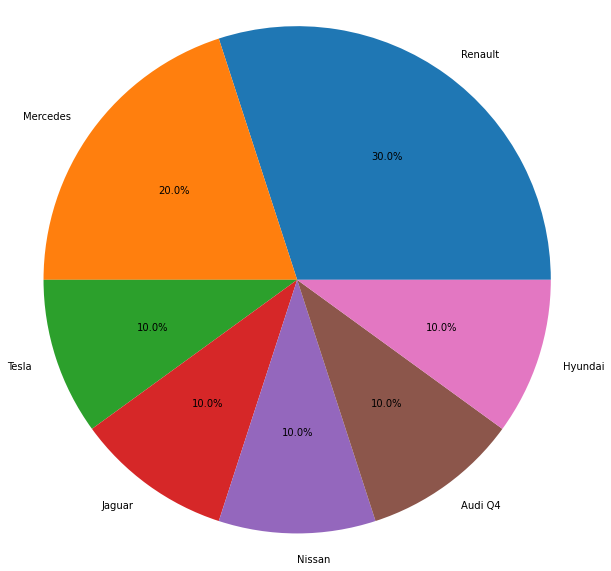

In [50]:
# Plot the population brand in a pie chart

# Values of each group
plt.figure(figsize=(10, 10))

brand_values = aggregator.simulation_dataframes['population']['brand'].value_counts()
plt.pie(brand_values, labels=brand_values.index, autopct='%1.1f%%')

# View the plot
plt.axis('equal')
plt.show()

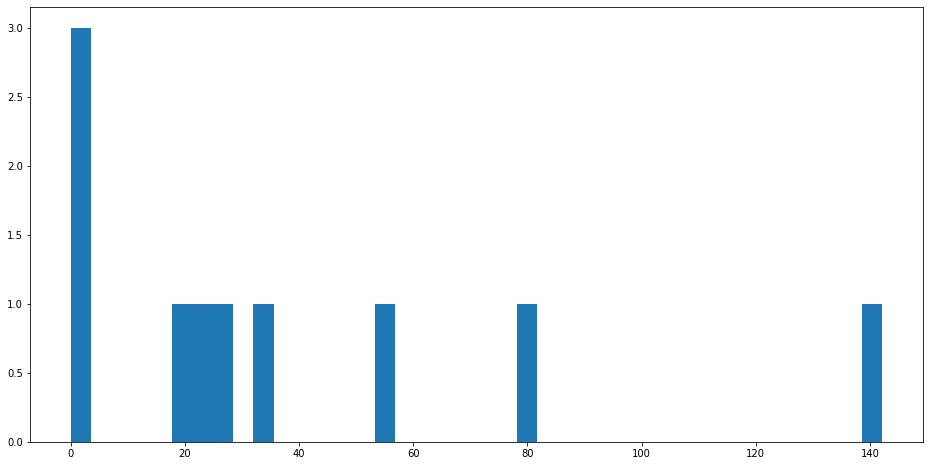

In [51]:
# Plot the trip distances in a histogram

plt.figure(figsize=(16, 8))

plt.hist(aggregator.simulation_dataframes['assigned_trips']['trip_length'], bins=40)
plt.show()

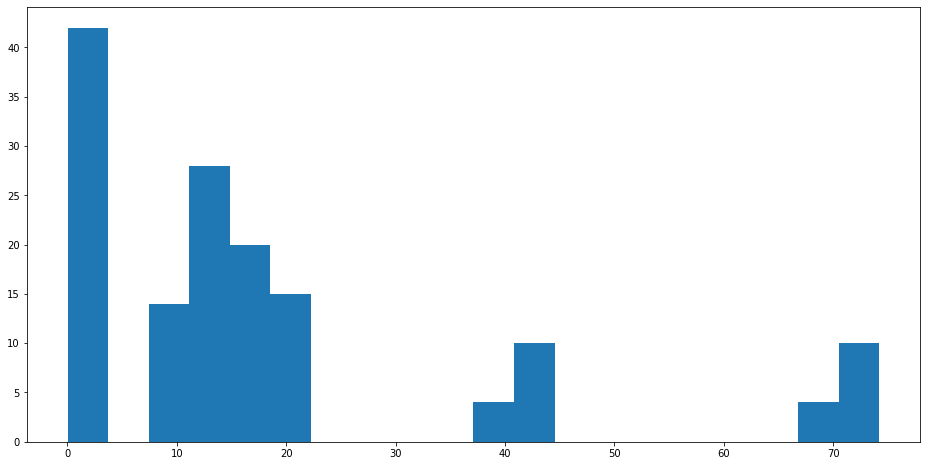

In [52]:
# Plot the segment distances in a histogram

plt.figure(figsize=(16, 8))

plt.hist(aggregator.simulation_dataframes['assigned_segments']['trip_length'], bins=20)
plt.show()

In [53]:
aggregator.simulation_dataframes['assigned_trips']['trip_length'].mean()

38.376

In [54]:
# EV charging history

aggregator.simulation_dataframes['cs_history']

,start_time,end_time,start_soc,end_soc,ev_id,station_type,station_power
0,2023-01-01 18:29:00.904849,2023-01-01 19:22:01.830775,0.889891,0.988989,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,Residential Slow (7.2 kW),7.2
1,2023-01-02 18:31:00.896636,2023-01-02 18:36:22.137377,0.988880,0.998888,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,Residential Slow (7.2 kW),7.2
2,2023-01-03 18:25:00.909281,2023-01-03 18:25:36.181503,0.998779,0.999878,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,Residential Slow (7.2 kW),7.2
3,2023-01-04 18:28:00.888419,2023-01-04 18:28:07.563789,0.999769,0.999977,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,Residential Slow (7.2 kW),7.2
4,2023-01-05 18:35:00.900878,2023-01-05 18:35:04.716563,0.999868,0.999987,60e6ccdbd1e5c4f9b7ab8c7fe73c1707,Residential Slow (7.2 kW),7.2
...,...,...,...,...,...,...,...
78,2023-01-02 18:39:21.893260,2023-01-02 20:24:43.115482,0.578585,0.957859,29ec69f035940b4800c087c8324eccc1,Residential Slow (3.6 kW),3.6
79,2023-01-03 18:46:55.634849,2023-01-03 20:33:14.423738,0.574747,0.957475,29ec69f035940b4800c087c8324eccc1,Residential Slow (3.6 kW),3.6
80,2023-01-04 18:38:27.293186,2023-01-04 20:22:25.172075,0.584141,0.958414,29ec69f035940b4800c087c8324eccc1,Residential Slow (3.6 kW),3.6
81,2023-01-05 18:38:50.487938,2023-01-05 20:25:25.386938,0.573673,0.957367,29ec69f035940b4800c087c8324eccc1,Residential Slow (3.6 kW),3.6


In [55]:
np.sum(aggregator.simulation_dataframes['ev_charging_history'] > 0)

2023-01-01 00:00:00    0
2023-01-01 01:00:00    0
2023-01-01 02:00:00    0
2023-01-01 03:00:00    0
2023-01-01 04:00:00    0
                      ..
2023-01-07 19:00:00    1
2023-01-07 20:00:00    0
2023-01-07 21:00:00    0
2023-01-07 22:00:00    0
2023-01-07 23:00:00    0
Freq: H, Length: 168, dtype: int64

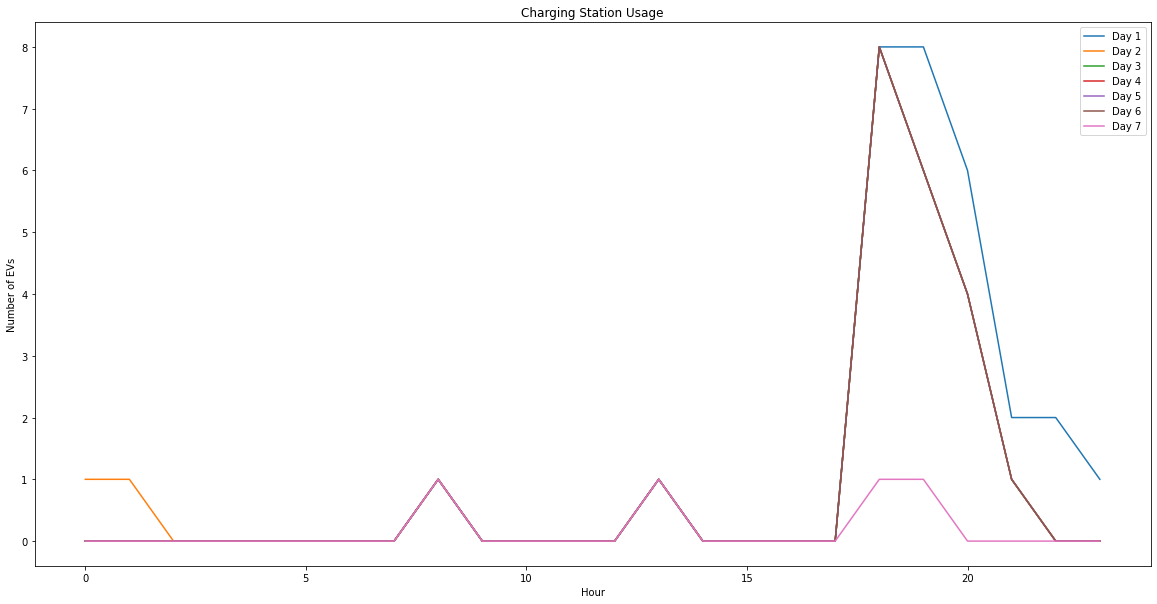

In [56]:

# Pick a Day. If None, every day is plotted

DAY = None

# Create a figure
fig = plt.figure(figsize=(20, 10))

# Plot the data
if DAY is not None:
    plt.plot(np.sum(aggregator.simulation_dataframes['ev_charging_history'].transpose().loc[DAY].transpose() > 0, axis=0).ravel())
else:
    for i in range(1, aggregator.simulation_cycles + 1):
        plt.plot(np.sum(aggregator.simulation_dataframes['ev_charging_history'].transpose().loc['2023-01-{:02d}'.format(i)].transpose() > 0, axis=0).ravel())

# Set the title
plt.title('Charging Station Usage')

# Set the x-axis label
plt.xlabel('Hour')

# Set the y-axis label
plt.ylabel('Number of EVs')

# Set the legend
if DAY is not None:
    plt.legend(['Day {}'.format(DAY)])
else:
    plt.legend(['Day {}'.format(i) for i in range(1, len(aggregator.simulation_dataframes) + 1)])

plt.show()

In [57]:
aggregator.simulation_dataframes['ev_charging_type']

,2023-01-01 00:00:00,2023-01-01 01:00:00,2023-01-01 02:00:00,2023-01-01 03:00:00,2023-01-01 04:00:00,2023-01-01 05:00:00,2023-01-01 06:00:00,2023-01-01 07:00:00,2023-01-01 08:00:00,2023-01-01 09:00:00,...,2023-01-07 14:00:00,2023-01-07 15:00:00,2023-01-07 16:00:00,2023-01-07 17:00:00,2023-01-07 18:00:00,2023-01-07 19:00:00,2023-01-07 20:00:00,2023-01-07 21:00:00,2023-01-07 22:00:00,2023-01-07 23:00:00
60e6ccdbd1e5c4f9b7ab8c7fe73c1707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f609b88f3e96af8fb0dc57c97cf3c64a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73ed7a52159d7182ccdbc3d27bd618dd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324fce82ce405dba34ed2bda2ef5e1b1,0,0,0,0,0,0,0,0,Private Semi-fast (22 kW),0,...,0,0,0,0,0,0,0,0,0,0
c224a4e2c8c84b016c13b8625f7feaeb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Public Fast (50 kW),Public Fast (50 kW),0,0,0,0
109647cfbf344aafe275a11202c75cf8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2e5462a851a28200237dd6193778934b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1a96f639364a8320e86446cb72375da6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fe01331fc0b4317f73fc47feb5e0e0e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29ec69f035940b4800c087c8324eccc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


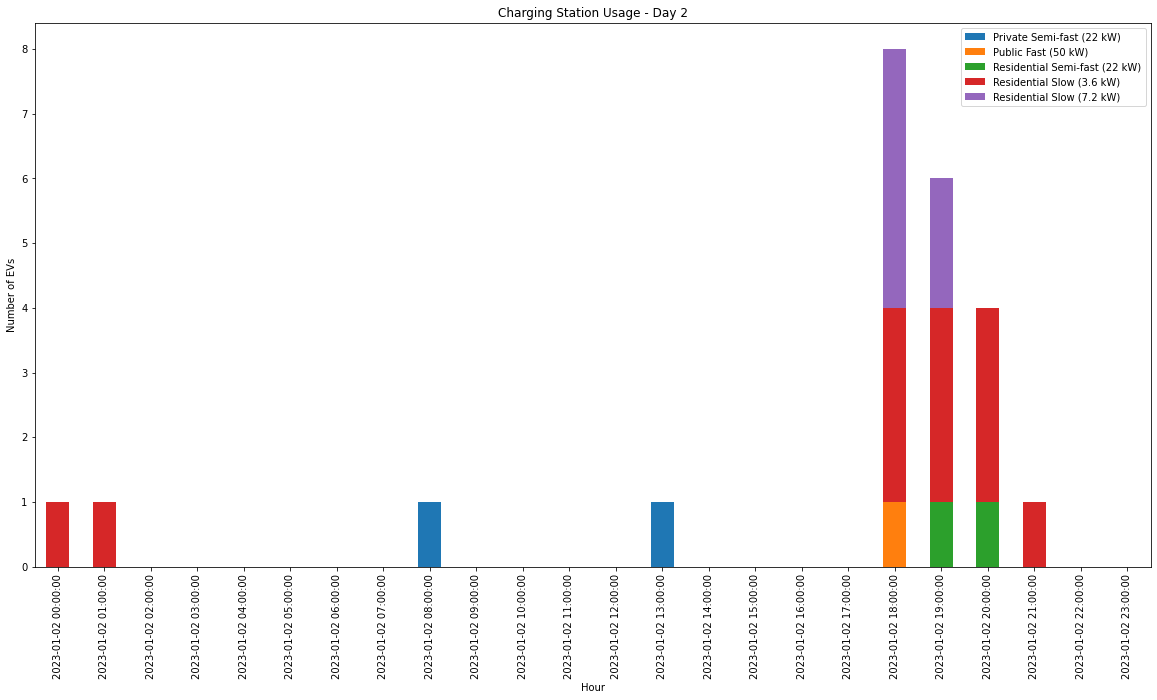

In [58]:
# Plot a stacked bar chart of the ev_charging_history_type_hourly DataFrame

DAY = 2

# Get the value counts of each charging type at each hour
ev_charging_history_type_hourly_value_counts = aggregator.simulation_dataframes['ev_charging_type'].transpose().loc['2023-01-{:02d}'.format(DAY)].transpose().apply(pd.value_counts, axis=0)
ev_charging_history_type_hourly_value_counts.drop(0, inplace=True)
ev_charging_history_type_hourly_value_counts = ev_charging_history_type_hourly_value_counts.fillna(0)

# Plot the data
ev_charging_history_type_hourly_value_counts.transpose().plot(kind='bar', stacked=True, figsize=(20, 10))

# Set the title
plt.title('Charging Station Usage - Day {}'.format(DAY))

# Set the x-axis label
plt.xlabel('Hour')

# Set the y-axis label
plt.ylabel('Number of EVs')

plt.show()

In [59]:
# EV Stopped History

aggregator.simulation_dataframes['ev_stopped']

,2023-01-01 00:00:00,2023-01-01 01:00:00,2023-01-01 02:00:00,2023-01-01 03:00:00,2023-01-01 04:00:00,2023-01-01 05:00:00,2023-01-01 06:00:00,2023-01-01 07:00:00,2023-01-01 08:00:00,2023-01-01 09:00:00,...,2023-01-07 14:00:00,2023-01-07 15:00:00,2023-01-07 16:00:00,2023-01-07 17:00:00,2023-01-07 18:00:00,2023-01-07 19:00:00,2023-01-07 20:00:00,2023-01-07 21:00:00,2023-01-07 22:00:00,2023-01-07 23:00:00
60e6ccdbd1e5c4f9b7ab8c7fe73c1707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f609b88f3e96af8fb0dc57c97cf3c64a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73ed7a52159d7182ccdbc3d27bd618dd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324fce82ce405dba34ed2bda2ef5e1b1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
c224a4e2c8c84b016c13b8625f7feaeb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
109647cfbf344aafe275a11202c75cf8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2e5462a851a28200237dd6193778934b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1a96f639364a8320e86446cb72375da6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fe01331fc0b4317f73fc47feb5e0e0e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29ec69f035940b4800c087c8324eccc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Check when the EVs are stopped

stopped_df = aggregator.simulation_dataframes['ev_stopped'].apply(pd.value_counts, axis=0)
stopped_df.fillna(0, inplace=True)
stopped_df = stopped_df.transpose()
stopped_df.columns = ['Driving', 'Stopped']

stopped_df

,Driving,Stopped
2023-01-01 00:00:00,10.0,0.0
2023-01-01 01:00:00,10.0,0.0
2023-01-01 02:00:00,10.0,0.0
2023-01-01 03:00:00,10.0,0.0
2023-01-01 04:00:00,10.0,0.0
...,...,...
2023-01-07 19:00:00,9.0,1.0
2023-01-07 20:00:00,10.0,0.0
2023-01-07 21:00:00,10.0,0.0
2023-01-07 22:00:00,10.0,0.0


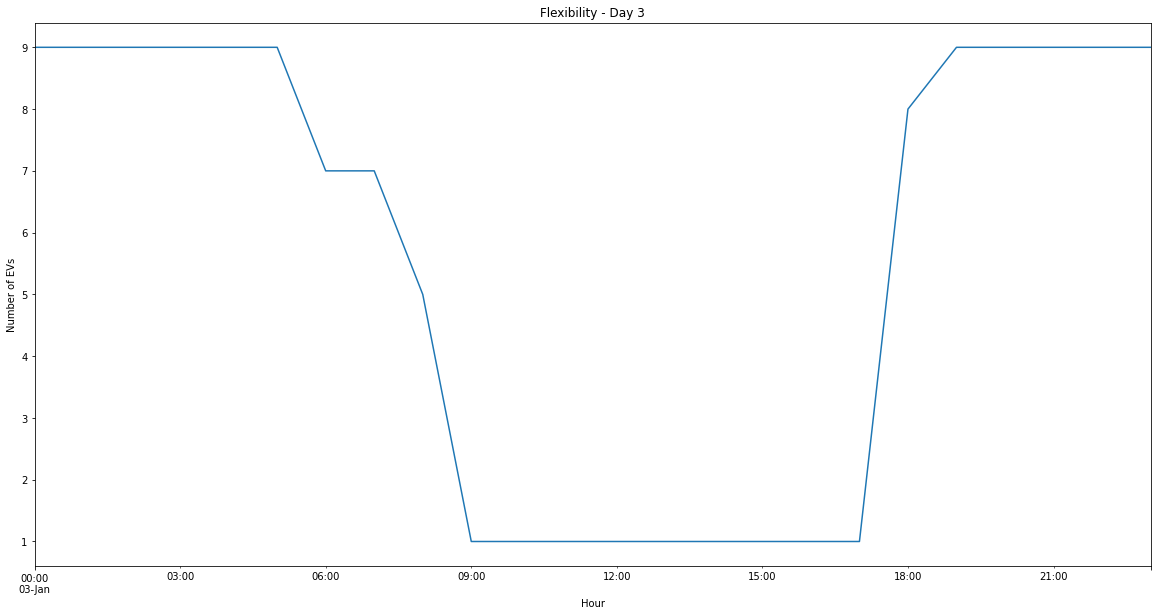

In [61]:
# Plot a stacked bar chart of the ev_stopped DataFrame

DAY = 3

plt.figure(figsize=(20, 10))

# Get the value counts of each charging type at each hour
np.sum(aggregator.simulation_dataframes['ev_flexibility'].transpose().loc['2023-01-{:02d}'.format(DAY)], axis=1).plot()

# Set the title
plt.title('Flexibility - Day {}'.format(DAY))

# Set the x-axis label
plt.xlabel('Hour')

# Set the y-axis label
plt.ylabel('Number of EVs')

# Set the y-axis to an integer
#plt.yticks(np.arange(0, aggregator.number_of_evs))

plt.show()

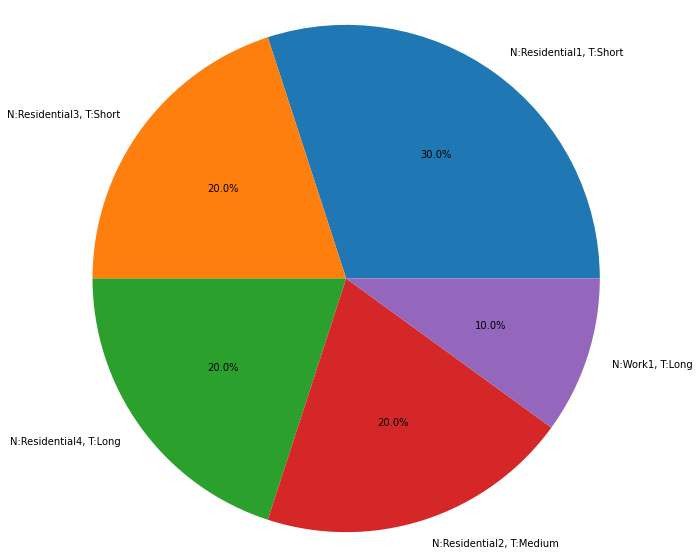

In [62]:
# Plot a pie chart of the user profiles

plt.figure(figsize=(10, 10))

# Values of each group
profile_values = aggregator.simulation_dataframes['population']['user_profile'].value_counts()
plt.pie(profile_values, labels=profile_values.index, autopct='%1.1f%%')

# View the plot
plt.axis('equal')

plt.show()

In [63]:
# Flexibility power

aggregator.simulation_dataframes['ev_flexibility_power']

,2023-01-01 00:00:00,2023-01-01 01:00:00,2023-01-01 02:00:00,2023-01-01 03:00:00,2023-01-01 04:00:00,2023-01-01 05:00:00,2023-01-01 06:00:00,2023-01-01 07:00:00,2023-01-01 08:00:00,2023-01-01 09:00:00,...,2023-01-07 14:00:00,2023-01-07 15:00:00,2023-01-07 16:00:00,2023-01-07 17:00:00,2023-01-07 18:00:00,2023-01-07 19:00:00,2023-01-07 20:00:00,2023-01-07 21:00:00,2023-01-07 22:00:00,2023-01-07 23:00:00
60e6ccdbd1e5c4f9b7ab8c7fe73c1707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f609b88f3e96af8fb0dc57c97cf3c64a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73ed7a52159d7182ccdbc3d27bd618dd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324fce82ce405dba34ed2bda2ef5e1b1,0,0,0,0,0,0,0,0,22,22,...,22,22,22,22,22,0,0,0,0,0
c224a4e2c8c84b016c13b8625f7feaeb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109647cfbf344aafe275a11202c75cf8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2e5462a851a28200237dd6193778934b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1a96f639364a8320e86446cb72375da6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fe01331fc0b4317f73fc47feb5e0e0e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29ec69f035940b4800c087c8324eccc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

# input - simulador - output
# input - NN - output

# modelação de sistemas ciberfisicos -> criar uma ferramenta para criar o simulador
# building information models

# domain specific languages
# utilização modelica para simulação
# comparação simulador com modelica

# model driven engineering

In [14]:
# Save all the simulation dataframes to a individual CSV files

import os

# Create the directory
if not os.path.exists('simulation_dataframes'):
    os.makedirs('simulation_dataframes')

for current_df in aggregator.simulation_dataframes.keys():
    aggregator.simulation_dataframes[current_df].to_csv('simulation_dataframes/{}_{}.csv'.format(current_df, aggregator.simulation_cycles))